In [1]:

import xarray as xr
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import matplotlib.cm as cm
import os
import matplotlib.animation as animation
import intake
from datetime import datetime,timedelta
import geopandas as gpd
from analysisFuncs import applyFunc, plot_map, getRegion, my_cmap
from analysisFuncs import regions, ens_list, templates, gcm_yr_list
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap

region = 'HI'
r = regions[region]



t_mean
pcp
t_range


/glade/work/shartke/conda-envs/samEnv/lib/python3.7/site-packages/ipykernel_launcher.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


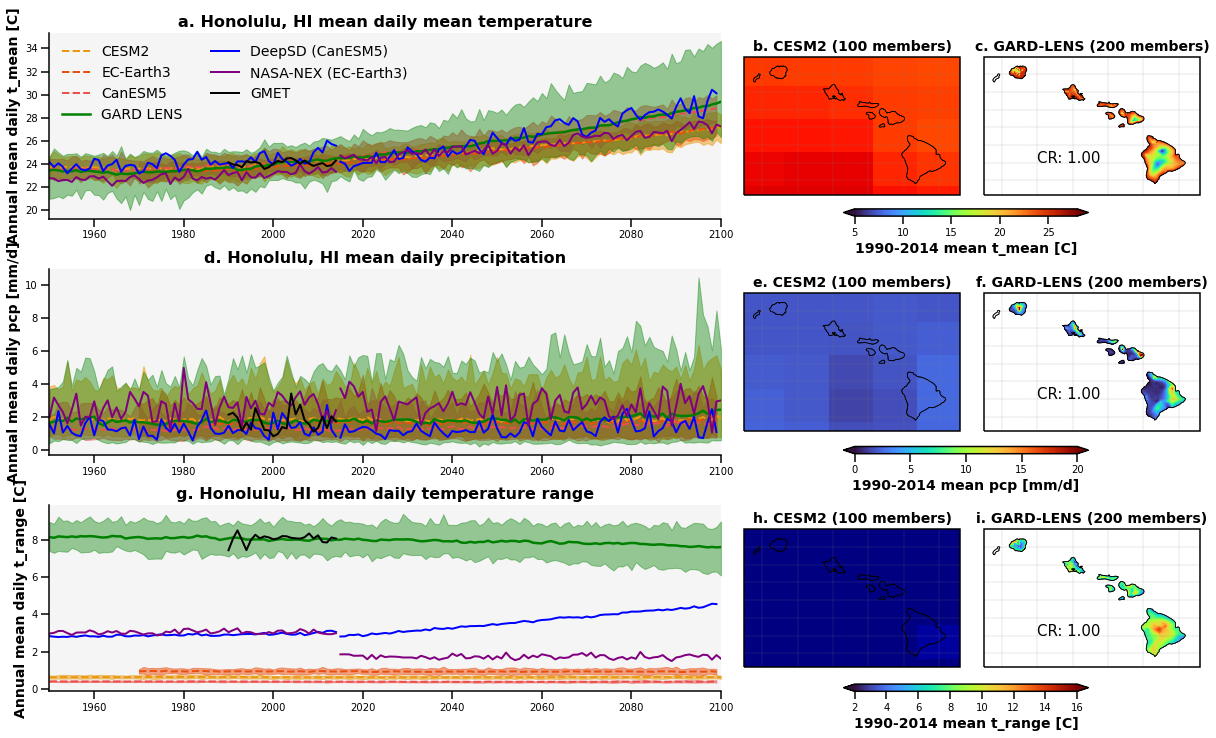

In [2]:


# Plot timeseries of pcp, t_mean, and t_range for Honolulu along with
# maps of the each variable and CR during historical period

gcm_dict = {'cesmlens2':('CESM2','#EB980E'),
           'ecearth3':('EC-Earth3','#EB4F0E'),
           'canesm5':('CanESM5','#EB4F4A')}

var_longnames = {'pcp':'daily precipitation',
                't_mean':'daily mean temperature',
                't_range':'daily temperature range'}

units = {'pcp':'mm/d',
         't_mean':'C',
         't_range':'C'}

v_dict = {'t_mean':(5,28),
         't_range':(2,16),
         'pcp':(0,20)}


proj = ccrs.PlateCarree()

gmet =  xr.open_dataset('/glade/campaign/ral/hap/hartke/stat_files/GMET_stats_HI.nc')
gmet = gmet.assign_coords(lon=gmet.longitude.values[0,:])
gmet = gmet.assign_coords(lat=gmet.latitude.values[0,:])
gmet_mask = gmet['t_mean_mean'].mean('year')

letters = ('a.','b.','c.','d.','e.','f.','g.','h.','i.')

fig = plt.figure(figsize=(17,10))
# Define the grid layout
gs = gridspec.GridSpec(3, 4, height_ratios=[1, 1, 1], width_ratios=[1, 2, 1, 1])

stat = 'mean'

i=0
for var in ('t_mean','pcp','t_range'):
    print(var)
    gardlens = xr.open_dataset('/glade/campaign/ral/hap/hartke/stat_files/GARDLENS_%s_stats_HI.nc'%var)[stat]
    
    # Calculate containing ratio
    gmet_mean = gmet['%s_%s'%(var,stat)].mean('year')
    gard_max = gardlens.sel(year=slice('1990','2014')).mean('year').max('n_ens')
    gard_min = gardlens.sel(year=slice('1990','2014')).mean('year').min('n_ens')
    cr = xr.full_like(gmet_mean, 1).where((gmet_mean<gard_max.values) & (gmet_mean>gard_min.values))
    tot_cells = gmet_mean.where(~np.isnan(gmet_mask),drop=True).count(('lat','lon')).values
    cr = (cr.where(~np.isnan(gmet_mask),drop=True).count().values/tot_cells)
    
    ax1 = fig.add_subplot(gs[i,3],projection=proj)
    gardlens_mean = gardlens.mean(('year','n_ens'))
    plot_map(gardlens_mean.where(gardlens_mean>0.000),ax=ax1,xlim=(-160.5,-154.4),ylim=(18.6,22.5),vmin=v_dict[var][0],vmax=v_dict[var][1],
             bottom=False,left=False,cmap='turbo',colorbar=False)
    ax1.set_aspect('equal') # ax1.set_aspect('auto')
    ax1.annotate('CR: %.02f'%cr,xy=(-159.,19.5),xycoords='data',fontsize=15)
    ax1.set_title('%s GARD-LENS (200 members)'%letters[3*i+2],fontsize=14)

    gardlensHONL = getRegion(gardlens,regions['HONL'])

    
    ax1 = fig.add_subplot(gs[i,0:2])

    
    for g in ('cesmlens2','ecearth3','canesm5'):
        gcm = xr.open_dataset('/glade/campaign/ral/hap/hartke/stat_files/%s_%s_stats_HI.nc'%(g,var))[stat]
        if g=='cesmlens2':
            ax2 = fig.add_subplot(gs[i,2],projection=proj)
            if var=='t_mean': gcm_mean = gcm.mean(('year','n_ens'))-273.15
            else: gcm_mean = gcm.mean(('year','n_ens'))
            im = plot_map(gcm_mean,ax=ax2,xlim=(-160.5,-154.4),ylim=(18.6,22.5),vmin=v_dict[var][0],vmax=v_dict[var][1],
                 bottom=False,left=False,cmap='turbo' if var=='pcp' else my_cmap,colorbar_label=var,colorbar=False)
            ax2.set_title('%s CESM2 (100 members)'%letters[3*i+1],fontsize=14)
            ax2.set_aspect('equal')
            
        gcm = getRegion(gcm,regions['HONL'])
        if var=='t_mean':
            gcm = gcm-273.15
        ax1.fill_between(gcm.year[:-1],gcm.min('n_ens')[:-1],gcm.max('n_ens')[:-1],alpha=0.5,
                        color = gcm_dict[g][1])
        ax1.plot(gcm.year[:-1],gcm.mean('n_ens')[:-1],linestyle='dashed',label=gcm_dict[g][0] if i==0 else '',
                c = gcm_dict[g][1])
        


    ax1.fill_between(gardlensHONL.year,gardlensHONL.min('n_ens'),gardlensHONL.max('n_ens'),alpha=0.4,color='g')
    ax1.plot(gardlensHONL.year,gardlensHONL.mean('n_ens'),label = 'GARD LENS' if i==0 else '',c='g',linewidth=2.5)

    deepsd = xr.open_dataset('/glade/campaign/ral/hap/hartke/stat_files/DeepSD_%s_stats.nc'%var)[stat]
    deepsd_hist = deepsd.where((deepsd.gcm=='canesm5')&(deepsd.scen=='historical'),drop=True)[0,:,:,:]
    deepsd_ssp370 = deepsd.where((deepsd.gcm=='canesm5')&(deepsd.scen=='ssp370'),drop=True)[0,:,:,:]
    deepsd = xr.concat((getRegion(deepsd_hist,regions['HONL']),getRegion(deepsd_ssp370,regions['HONL'])),dim='year')
    if var=='t_mean': ax1.plot(deepsd.year,deepsd-273.15,c='b',label='DeepSD (CanESM5)')
    else: ax1.plot(deepsd.year,deepsd,c='b')

    nex = xr.open_dataset('/glade/campaign/ral/hap/hartke/stat_files/NEX_%s_stats.nc'%var)[stat]
    nex = nex.sel(n_ens=nex.gcm=='ecearth3')
    nex_hist = nex.sel(n_ens=nex.scen=='historical')[0,:,:,:]
    nex_ssp370 = nex.sel(n_ens=nex.scen=='ssp370')[0,:,:,:]
    nex = xr.concat((getRegion(nex_hist,regions['HONL']),getRegion(nex_ssp370,regions['HONL'])),dim='year')
    if var=='t_mean': ax1.plot(nex.year,nex-273.15,c='purple',label='NASA-NEX (EC-Earth3)')
    else: ax1.plot(nex.year,nex,c='purple')
    
    gmetHONL = getRegion(gmet,regions['HONL'])
    ax1.plot(gmetHONL.year,gmetHONL['%s_%s'%(var,stat)],c='k',label='GMET' if i==0 else '')
    if i==0: ax1.legend(ncol=2,fontsize=14,loc="upper left")
    ax1.set_xlim((1950,2100))
    ax1.set_ylabel('Annual %s daily %s [%s]'%(stat,var,units[var]))
    ax1.spines['top'].set_visible(False); ax1.spines['right'].set_visible(False)
    ax1.set_title('%s Honolulu, HI mean %s'%(letters[3*i],var_longnames[var]))

    ax2 = fig.add_axes([0.7, 1.035-.33*(i+1), 0.2, 0.01])
    cb = mpl.colorbar.ColorbarBase(ax2, orientation='horizontal', 
                                   cmap='turbo',
                                   norm=mpl.colors.Normalize(vmin=v_dict[var][0],vmax=v_dict[var][1]),  # vmax and vmin
                                   extend='both',
                                   label='1990-2014 %s %s [%s]'%(stat,var,units[var]))

    i+=1

plt.tight_layout()

plt.savefig('figures/Figure_6_HI_%s_stats.jpg'%stat,bbox_inches='tight',dpi=1200)
plt.show()

